In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import inspect

## Happy house dataset

In [25]:
training_data = h5py.File("./happy_house/train_happy.h5", "r")
X_training = np.array(training_data["train_set_x"][:]) / 255
Y_training = np.array(training_data["train_set_y"][:])
Y_training = Y_training.reshape(Y_training.shape[0], 1)

test_data = h5py.File("./happy_house/test_happy.h5", "r")
X_test = np.array(test_data["test_set_x"][:]) / 255
Y_test = np.array(test_data["test_set_y"][:])
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [26]:
print("X_training: ", X_training.shape)
print("Y_training: ", Y_training.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)

X_training:  (600, 64, 64, 3)
Y_training:  (600, 1)
X_test:  (150, 64, 64, 3)
Y_test:  (150, 1)


[0]


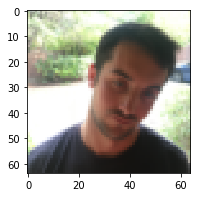

In [27]:
print(Y_training[0])
plt.figure(figsize=[3, 3])
plt.imshow(X_training[0])
plt.show()

## Modeling

Build the following CNN:

CONV -> BN -> RELU -> MAX POOL -> FLATTEN -> SIGMOID

**NOTE** on BN (Batch Normalization): It normalizes the values before applying activation functions, and can be applied in any layer of the NN. It is similar to normalizing the input X that makes each feature has zero mean and unit variance. But the difference is, Batch Normalization does not necessarily results in zero mean and unit variance; instead, it uses two learnable parameters $\gamma$ and $\beta$ (two for each hidden unit in that layer) to control the mean and scale. These parameters are learned in the same way with gradient descent as weights in the NN. Like normalizing input, BN can make learning faster.

There is another **important** note for BN on convolutional output. Suppose the input has shape `B x H0 x W0 x 3`, filter has shape `f x f x 3 x C1`, and output has shape `B x H1 x W1 x C1`. In the naive way, we can normalize over only the first batch dimension `B`, just as above for normal NN output. If so, then each unit (`H1 x W1 x C1` units in total) is normalized independently: it has its own mean and variance, and has its two learnable parameters $\gamma_{h, w, c}$ and $\beta_{h, w, c}$.  But for **convolutional layers**, we additionally want the normalization to obey the convolutional property: outputs resulted from the same filter ('C1' filters in total) are normalized in the same way. Hence, each channel is normalized with the same mean and variance, and has its learnable parameters $\gamma_{c}$ and $\beta_{c}$. Essentially, we use the **effective minibatch** of size `B x H1 x W1`.

Above is necessary for understanding the documentation of the two TensorFlow functions `tf.nn.batch_normalization` and `tf.contrib.layers.batch_norm`

In the implementation, one thing that might stand out is the `phase` term. We are going to use it as a placeholder for a boolean which we will insert into `feed_dict`. It will serve as a binary indicator for whether we are in training `phase=True` or testing `phase=False` mode. Recall that batch normalization has distinct behaviors during training verus test time:

>**Training**

> - Normalize layer activations according to mini-batch statistics.
- During the training step, update population statistics approximation via moving average of mini-batch statistics.

>**Testing**

> - Normalize layer activations according to estimated population statistics.
- Do not update population statistics according to mini-batch statistcs from test data.

## No BN, No minibatch --> Poor performance

In [28]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [44]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [5, 5, 3, 8], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [3, 3, 8, 16], initializer = tf.contrib.layers.xavier_initializer())
    
    parameters = {"W1": W1, "W2": W2}
    return parameters

In [45]:
def forward_propagation(X, parameters):
    """
    CONV -> RELU -> MAX POOL -> CONV -> RELU -> MAX POOL -> FLATTEN -> SIGMOID
    """
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = "SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = "SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 1, activation_fn=None)
    
    return Z3
    

In [46]:
def compute_cost(output, Y):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = output, labels = Y))
    #return -tf.reduce_mean(Y * tf.log(output) + (1 - Y) * tf.log(1 - output))

def compute_accuracy(output, Y):
    return tf.reduce_mean(tf.cast(tf.equal(tf.cast(output > 0, 'float32'), Y), 'float32'))

In [47]:
def model(X_training, Y_training, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 100):
    tf.reset_default_graph()        
    tf.set_random_seed(3947) # So weird that if I don't set the random seed, the network doesn't work because of weird initialization

    (m, n_H0, n_W0, n_C0) = X_training.shape
    n_y = Y_training.shape[1]
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    filters = initialize_parameters()
    output = forward_propagation(X, filters)
    cost = compute_cost(output, Y)
    accuracy = compute_accuracy(output, Y)
    
    train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    numpy_seed = 1
    train_accuracies = []
    test_accuracies = []
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for i in range(num_epochs):
                
            session.run(train_step, feed_dict = {X: X_training, Y: Y_training})
            print(session.run(cost, feed_dict = {X: X_training, Y: Y_training}))
                        
            train_accuracy = session.run(accuracy, feed_dict = {X: X_training, Y: Y_training})
            train_accuracies.append(train_accuracy)
            
            test_accuracy = session.run(accuracy, feed_dict = {X: X_test, Y: Y_test})
            test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies
    

In [48]:
train_accuracies, test_accuracies = model(X_training, Y_training, X_test, Y_test, learning_rate = 0.0001, num_epochs = 10)
# learning_rate is so critical here. Setting a bigger value (e.g., 0.01) makes the process meaningless 
# because the accuracies just oscillate around 0.5
 

0.688963
0.688156
0.687404
0.686687
0.685982
0.685278
0.684567
0.68385
0.683133
0.682418


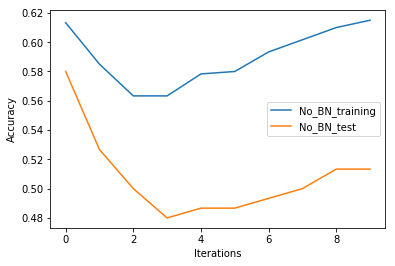

In [49]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(train_accuracies, label = "No_BN_training")
ax.plot(test_accuracies, label = "No_BN_test")
ax.legend(loc = "best")
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
plt.show()

In [ ]:
train_accuracies, test_accuracies = model(X_training, Y_training, X_test, Y_test, learning_rate = 0.0001, num_epochs = 30)
# learning_rate is so critical here. Setting a bigger value (e.g., 0.01) makes the process meaningless 
# because the accuracies just oscillate around 0.5

In [ ]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(train_accuracies, label = "No_BN_train")
ax.plot(test_accuracies, label = "No_BN_test")
ax.legend(loc = "best")
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
plt.show()

## With Minibatch

In [51]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (m, n_H, n_W, n_C)
    Y -- true "label" vector, of shape (m, #classes)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(k * mini_batch_size) : ((k + 1) * mini_batch_size), :]
        mini_batch_Y = shuffled_Y[(k * mini_batch_size) : ((k + 1) * mini_batch_size), :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(num_complete_minibatches * mini_batch_size) : m, :]
        mini_batch_Y = shuffled_Y[(num_complete_minibatches * mini_batch_size) : m, :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [56]:
def model_minibatch(X_training, Y_training, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 16):
    tf.reset_default_graph()        
    tf.set_random_seed(3947) # So weird that if I don't set the random seed, the network doesn't work because of weird initialization

    (m, n_H0, n_W0, n_C0) = X_training.shape
    n_y = Y_training.shape[1]
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    filters = initialize_parameters()
    output = forward_propagation(X, filters)
    cost = compute_cost(output, Y)
    accuracy = compute_accuracy(output, Y)
     
    train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    numpy_seed = 1
    train_accuracies = []
    test_accuracies = []
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for i in range(num_epochs):
            num_minibatches = m / minibatch_size
            numpy_seed = numpy_seed + 1
            minibatches = random_mini_batches(X_training, Y_training, minibatch_size, numpy_seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                session.run(train_step, feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
            print(session.run(cost, feed_dict = {X: X_training, Y: Y_training}))
                        
            train_accuracy = session.run(accuracy, feed_dict = {X: X_training, Y: Y_training})
            train_accuracies.append(train_accuracy)
            
            test_accuracy = session.run(accuracy, feed_dict = {X: X_test, Y: Y_test})
            test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies
    

In [59]:
train_accuracies_minibatch, test_accuracies_minibatch = model_minibatch(X_training, Y_training, X_test, Y_test, learning_rate = 0.001, num_epochs = 10)

0.667226
0.502302
0.329134
0.277815
0.202483
0.16907
0.190619
0.200192
0.125511
0.116463


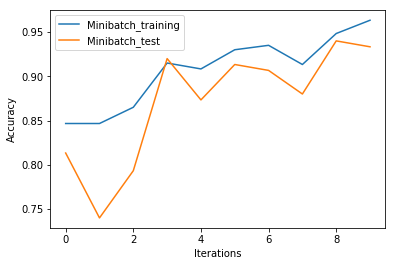

In [60]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(train_accuracies_minibatch, label = "Minibatch_training")
ax.plot(test_accuracies_minibatch, label = "Minibatch_test")
ax.legend(loc = "best")
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
plt.show()

## With minibatch, BN

In [75]:
def forward_propagation_bn(X, parameters, phase):
    """
    CONV -> BN -> RELU -> MAX POOL -> FLATTEN -> SIGMOID
    """
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = "SAME")
    # 'decay' param is critical below. The default value 0.999 does not work well in this example.
    # With 0.999, we got a super low test accuracy (around just 57%)
    # But with 0.9, we got a reasonable test accuracy 95%
    # I think decay rate 0.999 does not give a good estimation of population statistics
    BN1 = tf.contrib.layers.batch_norm(Z1, center=True, scale=True, is_training=phase, decay=0.9) 
    A1 = tf.nn.relu(BN1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = "SAME")
    BN2 = tf.contrib.layers.batch_norm(Z2, center = True, scale = True, is_training = phase, decay=0.9)
    A2 = tf.nn.relu(BN2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 1, activation_fn=None)
    
    return Z3
    

In [76]:
def model_bn(X_training, Y_training, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 16):
    tf.reset_default_graph()        
    tf.set_random_seed(3947) # So weird that if I don't set the random seed, the network doesn't work because of weird initialization

    (m, n_H0, n_W0, n_C0) = X_training.shape
    n_y = Y_training.shape[1]
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    phase = tf.placeholder(tf.bool)
    filters = initialize_parameters()
    output = forward_propagation_bn(X, filters, phase)
    cost = compute_cost(output, Y)
    accuracy = compute_accuracy(output, Y)
     
    # These three lines are necessary for telling TensorFlow to compute the moving average 
    # of mean and variance in batch normalization 
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Get the update operations
    with tf.control_dependencies(update_ops): # Everything inside this context is dependent on 'update_ops'
        # Ensures that we execute the update_ops before performing the train_step
        train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    numpy_seed = 1
    train_accuracies = []
    test_accuracies = []
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for i in range(num_epochs):
            num_minibatches = m / minibatch_size
            numpy_seed = numpy_seed + 1
            minibatches = random_mini_batches(X_training, Y_training, minibatch_size, numpy_seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                session.run(train_step, feed_dict = {X: minibatch_X, Y: minibatch_Y, phase: True})
                
            print(session.run(cost, feed_dict = {X: X_training, Y: Y_training, phase: False}))
                        
            train_accuracy = session.run(accuracy, feed_dict = {X: X_training, Y: Y_training, phase: False})
            train_accuracies.append(train_accuracy)
            
            test_accuracy = session.run(accuracy, feed_dict = {X: X_test, Y: Y_test, phase: False})
            test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies
    

In [77]:
train_accuracies_bn, test_accuracies_bn = model_bn(X_training, Y_training, X_test, Y_test, learning_rate = 0.001, num_epochs = 10)

0.443166
0.311995
0.1406
0.12509
0.179309
0.0854035
0.0577129
0.101101
0.0656323
0.0485306


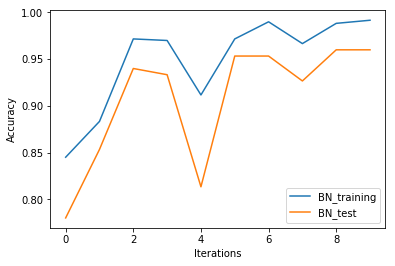

In [78]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(train_accuracies_bn, label = "BN_training")
ax.plot(test_accuracies_bn, label = "BN_test")
ax.legend(loc = "best")
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
plt.show()

In [80]:
train_accuracies_bn, test_accuracies_bn

([0.84500003,
  0.88333333,
  0.97166669,
  0.97000003,
  0.91166669,
  0.97166669,
  0.99000001,
  0.96666664,
  0.98833334,
  0.99166667],
 [0.77999997,
  0.85333335,
  0.94,
  0.93333334,
  0.81333333,
  0.95333332,
  0.95333332,
  0.92666668,
  0.95999998,
  0.95999998])